In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Building ARIMA Models
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.api as smt

# Libraries for Evaluation
from sklearn.metrics import mean_squared_error
from math import sqrt

KeyboardInterrupt: 

In [ ]:
%matplotlib inline

In [4]:
# load dataset
df_AAL = pd.read_csv('../datasets/AAL.csv', header=0, index_col=0)
df_AAL.head()

,Open,High,Low,Close,Volume
Date,,,,,
6/11/2018,43.25,44.93,43.25,44.16,"6,440,746"
6/12/2018,44.23,44.30,43.09,43.41,"5,204,620"
6/13/2018,43.39,43.69,42.83,42.92,"5,988,999"
6/14/2018,43.06,43.49,42.80,43.08,"4,019,334"
6/15/2018,43.06,43.11,42.32,42.77,"7,031,967"


<class 'pandas.core.frame.DataFrame'>
Index: 1258 entries, 6/11/2018 to 6/8/2023
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1258 non-null   float64
 1   High    1258 non-null   float64
 2   Low     1258 non-null   float64
 3   Close   1258 non-null   float64
 4   Volume  1258 non-null   object 
dtypes: float64(4), object(1)
memory usage: 59.0+ KB


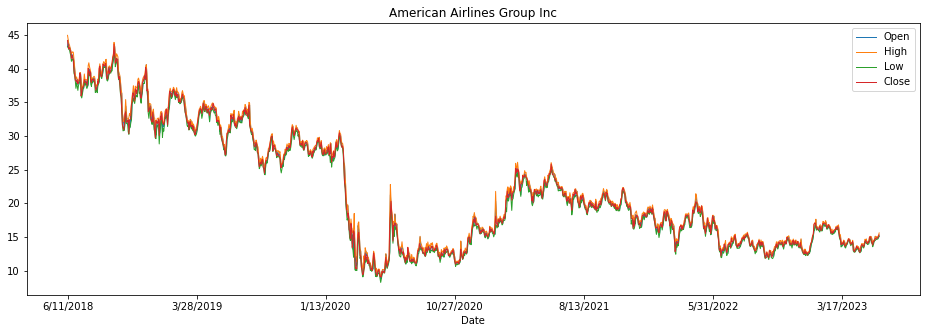

In [5]:
df_AAL.info()
df_AAL.plot(figsize=(16,5),lw=1, title="American Airlines Group Inc")
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

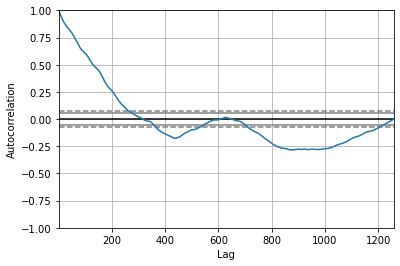

In [6]:
autocorrelation_plot(df_AAL[["Open","High","Low","Close"]])

In [7]:
df_AAL.describe()

,Open,High,Low,Close
count,1258.000000,1258.000000,1258.000000,1258.000000
mean,21.911812,22.329086,21.453895,21.864507
std,8.784553,8.854200,8.712301,8.777409
min,8.770000,9.190000,8.250000,9.040000
25%,14.267500,14.560000,13.930000,14.255000
50%,19.160000,19.555000,18.790000,19.135000
75%,28.977500,29.307500,28.567500,29.027500
max,44.230000,44.930000,43.250000,44.160000


In [8]:
# Convert index to datetime64
df_AAL.index = pd.to_datetime(df_AAL.index)
start = df_AAL.index.min()
end = df_AAL.index.max()
print('Start date: ', start)
print('End date: ', end)

Start date:  2018-06-11 00:00:00
End date:  2023-06-08 00:00:00


### Choosing Close Columns for model predictions

<class 'pandas.core.series.Series'>
DatetimeIndex: 1258 entries, 2018-06-11 to 2023-06-08
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
1258 non-null   float64
dtypes: float64(1)
memory usage: 19.7 KB


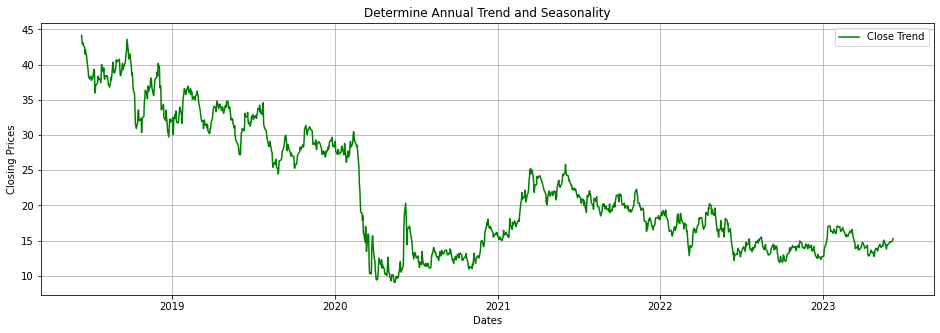

In [9]:
# Select close column for fitting the model
df_close = df_AAL["Close"]
df_close.info()

# Observe Close dataset
plt.figure(figsize=(16,5))
plt.grid(True)
plt.title('Determine Annual Trend and Seasonality')
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_close, 'green', label='Close Trend')
plt.legend()
plt.show()

In [10]:
# Check index data type of datetime64
print(type(df_close.index))
print(df_close.index.inferred_type == "datetime64")
df_close.head()

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
True


Date
2018-06-11    44.16
2018-06-12    43.41
2018-06-13    42.92
2018-06-14    43.08
2018-06-15    42.77
Name: Close, dtype: float64

## Exploratory Analysis / Preprocessing

In [11]:
df_close.describe()

count    1258.000000
mean       21.864507
std         8.777409
min         9.040000
25%        14.255000
50%        19.135000
75%        29.027500
max        44.160000
Name: Close, dtype: float64

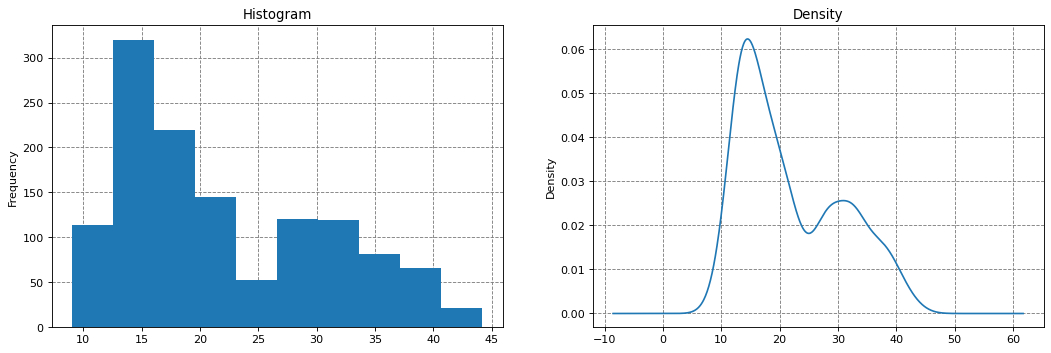

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), dpi=80)
df_close.plot(title='Histogram', kind='hist', ax=ax1)
ax1.set_axisbelow(True)
ax1.grid(color='gray', linestyle='dashed')
df_close.plot(title='Density', kind='kde', ax=ax2)
ax2.grid(color='gray', linestyle='dashed')
plt.show()

In [13]:
df_close.skew() 

0.6306730123189014

A right-skewed and left-skewed distribution are represented by a positive and negative value, respectively. Values closer to zero denote a less skewed distribution.

### Find Outliers

In [14]:
## For outliers detection
from sklearn import preprocessing, svm

In [107]:
'''
Find outliers using sklearn unsupervised support vector machine.
:parameter
    :param ts: pandas Series
    :param perc: float - percentage of outliers to look for
:return
    dtf with raw ts, outlier 1/0 (yes/no), numeric index
'''
def find_outliers(ts, perc=0.01, figsize=(15,5)):
    ## fit svm
    scaler = preprocessing.StandardScaler()
    ts_scaled = scaler.fit_transform(ts.values.reshape(-1,1))
    model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
    model.fit(ts_scaled)
    ## dtf output
    dtf_outliers = ts.to_frame(name="ts")
    dtf_outliers["index"] = range(len(ts))
    dtf_outliers["outlier"] = model.predict(ts_scaled)
    dtf_outliers["outlier"] = dtf_outliers["outlier"].apply(lambda
                                              x: 1 if x==-1 else 0)
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.set(title="Outliers detection: found"
           +str(sum(dtf_outliers["outlier"]==1)))
    ax.plot(dtf_outliers["index"], dtf_outliers["ts"],
            color="green")
    ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1]["index"],
               y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'],
               color='red')
    ax.grid(True)
    plt.show()
    return dtf_outliers

In [16]:
'''
Interpolate outliers in a ts.
'''
def remove_outliers(ts, outliers_idx, figsize=(15,5)):
    ts_clean = ts.copy()
    ts_clean.loc[outliers_idx] = np.nan
    ts_clean = ts_clean.interpolate(method="linear")
    ax = ts.plot(figsize=figsize, color="red", alpha=0.5,
         title="Remove outliers", label="original", legend=True)
    ts_clean.plot(ax=ax, grid=True, color="green",
                  label="interpolated", legend=True)
    plt.show()
    return ts_clean

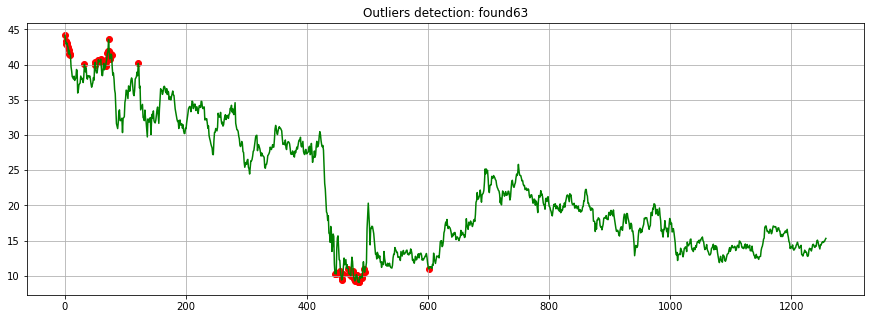

In [108]:
dtf_outliers = find_outliers(df_close, perc=0.05)

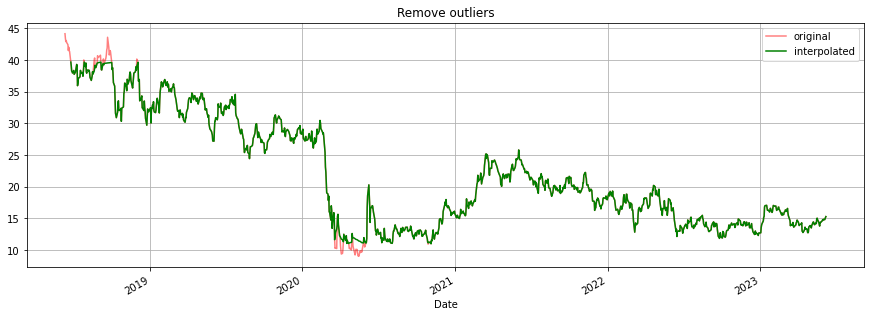

In [18]:
## outliers index position
outliers_index_pos = dtf_outliers[dtf_outliers["outlier"]==1].index
## exclude outliers
ts_clean = remove_outliers(df_close, outliers_idx=outliers_index_pos)

In [19]:
ts_clean = ts_clean.dropna()
ts_clean.head()

Date
2018-06-25    39.68
2018-06-26    39.09
2018-06-27    38.26
2018-06-28    38.20
2018-06-29    37.96
Name: Close, dtype: float64

## Determining ARIMA parameter p,d,q

In [20]:
# Creating function to display ACF anf PACF plot
def plot_correlation(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), dpi=80)
    # ACF
    plot_acf(df, ax=ax1, lags=30)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    
    # PACF
    plot_pacf(df, ax=ax2, lags=60)
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')

    # Lighten the borders
    ax1.spines['top'].set_alpha(.3); ax2.spines['top'].set_alpha(.3)
    ax1.spines['bottom'].set_alpha(.3); ax2.spines['bottom'].set_alpha(.3)
    ax1.spines['right'].set_alpha(.3); ax2.spines['right'].set_alpha(.3)
    ax1.spines['left'].set_alpha(.3); ax2.spines['left'].set_alpha(.3)

    ax1.tick_params(axis='both', labelsize=10)
    ax2.tick_params(axis='both', labelsize=10)
    plt.show()

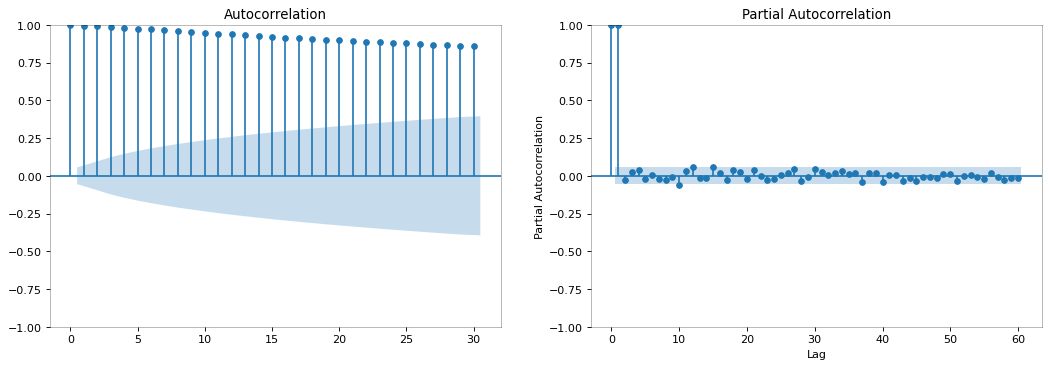

In [21]:
plot_correlation(ts_clean)

### Get p-value with ADF and KPSS test

In [22]:
#perform augmented Dickey-Fuller test to check if stationary
def ADF(df):
    result = adfuller(df)

    # Extract ADF Values
    print('Column Name: %s' % "Close Variable")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [23]:
ADF(ts_clean)

Column Name: Close Variable
ADF Statistic: -2.105159
p-value: 0.242445
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


### Transform to stationary

In [24]:
# Perform differencing
def to_stationary(df):
    cycle = 0
    df_diff = df.diff().dropna()
    cycle += 1
    if df_diff[1] <= 0.05:
        print(f"p.value: {df_diff[1]}")
        print(f"Cycle of differencing: {cycle}")
        return df_diff
    else:
        return to_stationary(df_diff)

p.value: -0.8300000000000054
Cycle of differencing: 1


<AxesSubplot:title={'center':'Close Trend After Differencing'}, xlabel='Date'>

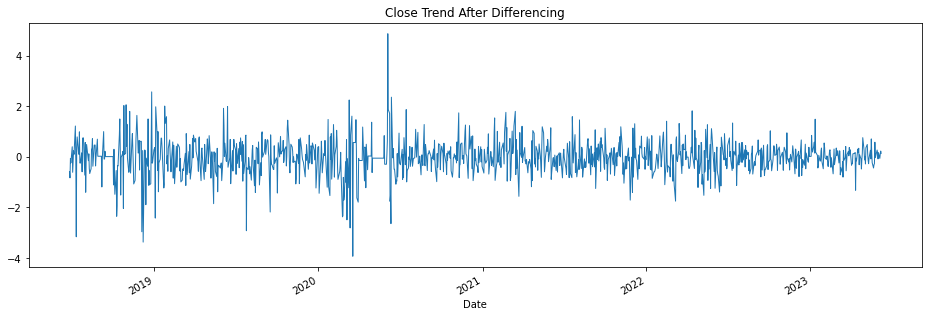

In [25]:
df_ts_diff = to_stationary(ts_clean)
df_ts_diff.plot(figsize=(16,5), lw=1, title="Close Trend After Differencing")

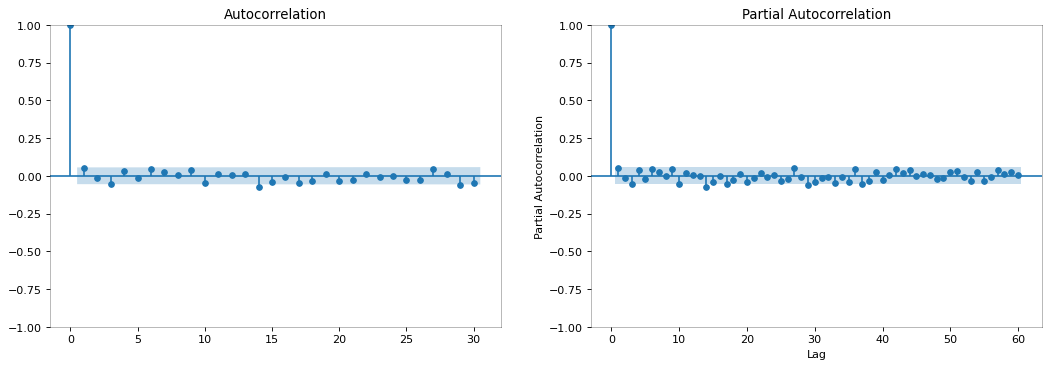

In [26]:
plot_correlation(df_ts_diff)

In [27]:
ADF(df_ts_diff)

Column Name: Close Variable
ADF Statistic: -33.605804
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


### Decompose to Observe Trend and Seasonality

In [28]:
def decompose_ts(df, period):
    decomposition = smt.seasonal_decompose(df, period=period)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid   
    fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, sharey=False, figsize=(16,16))
    ax[0].plot(df)
    ax[0].set_title('Original')
    ax[0].grid(True) 
    ax[1].plot(trend)
    ax[1].set_title('Trend')
    ax[1].grid(True)  
    ax[2].plot(seasonal)
    ax[2].set_title('Seasonality')
    ax[2].grid(True)  
    ax[3].plot(residual)
    ax[3].set_title('Residuals')
    ax[3].grid(True)

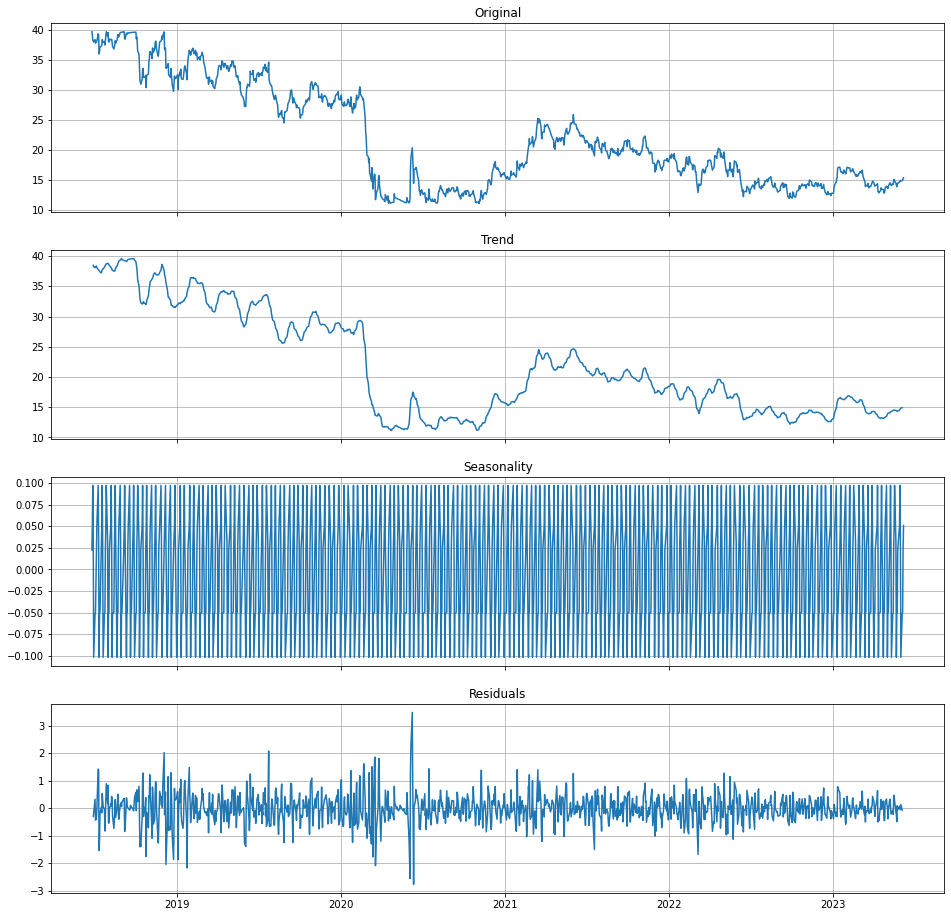

In [29]:
decompose_ts(ts_clean,7)

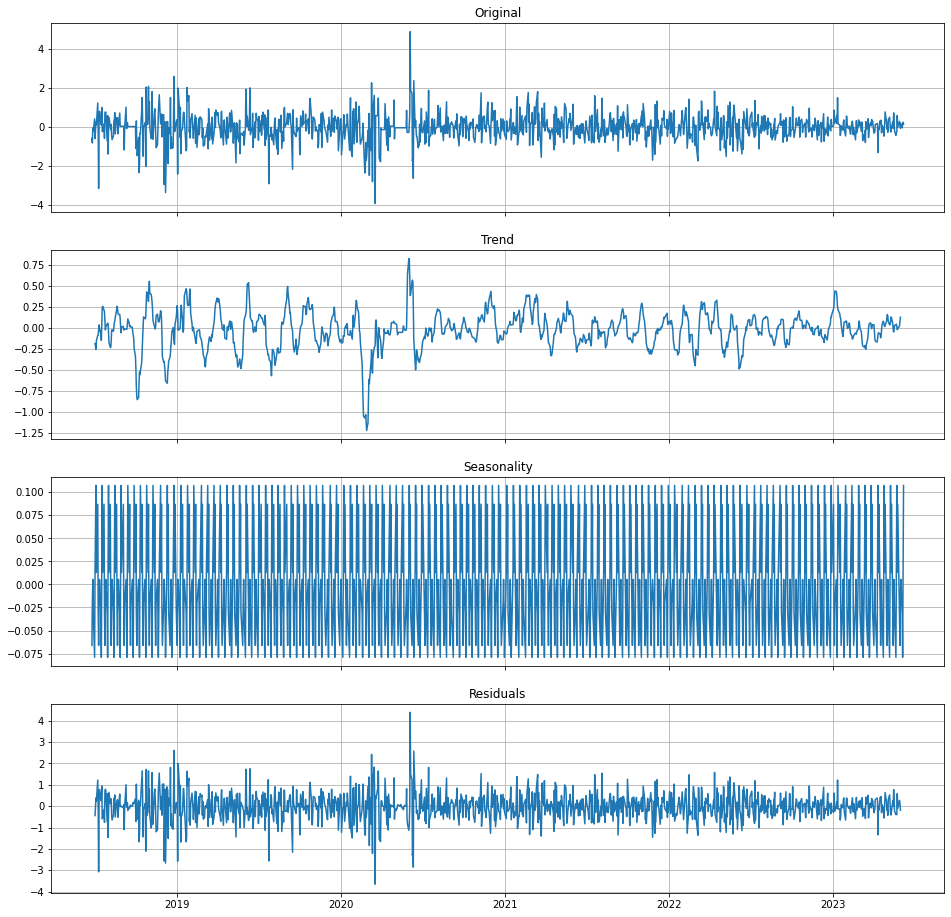

In [34]:
# Decompose for stationary dataset
decompose_ts(df_ts_diff,10)

**********************************************************************************************************************

### Get value of ARIMA - For ARIMA app

In [ ]:
p = int(input('Enter Autoregressive (p) value: '))
d = int(input('Enter Differencing (d) value: '))
q = int(input('Enter Moving Average (q) value: '))
ARIMA_order = (p ,d,q)

**********************************************************************************************************************

## Split data for train and test

In [85]:
# Split the data for train and test
row_len = int(len(ts_clean)*0.9)
df_train = list(ts_clean[0:row_len].copy())
df_test = list(ts_clean[row_len:].copy())

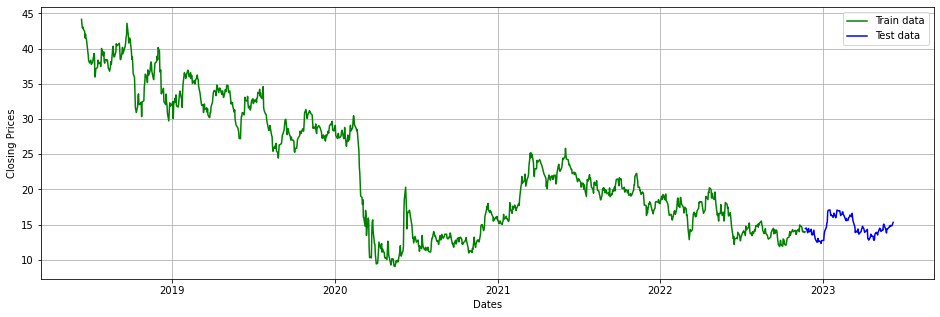

In [86]:
# Plot training and testing data
plt.figure(figsize=(16,5))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_close[0:row_len], 'green', label='Train data')
plt.plot(df_close[row_len:], 'blue', label='Test data')
plt.legend()
plt.show()

## Fit the ARIMA Model

In [87]:
# Function that extract model train according to given length
residuals = []
def model_fit(length):
    model_predictions = []
    
    for i in range(length):
        model = ARIMA(df_train, order=(1,1,1))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        residuals.append(df_train[i] - yhat)
        model_predictions.append(yhat)
        actual_test_value = df_test[i]
        df_train.append(actual_test_value)

    print(len(model_predictions))
    print(model_fit.summary())
    
    return model_predictions

In [88]:
# For model prediction for whole train set
n_test_observ = len(df_test)
model_prediction = model_fit(n_test_observ)

125
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1247
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1302.222
Date:                Mon, 17 Jul 2023   AIC                           2610.444
Time:                        12:39:55   BIC                           2625.827
Sample:                             0   HQIC                          2616.228
                               - 1247                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0286      0.396     -0.072      0.942      -0.805       0.748
ma.L1          0.0785      0.397      0.198      0.843      -0.700       0.857
sigma2         0.4735      0.010     46.357     

In [95]:
# For extended prediction using previous model prediction
extend_predict = model_fit(10)

10
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1257
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1312.180
Date:                Mon, 17 Jul 2023   AIC                           2630.360
Time:                        12:42:08   BIC                           2645.768
Sample:                             0   HQIC                          2636.151
                               - 1257                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0412      0.403     -0.102      0.918      -0.831       0.749
ma.L1          0.0901      0.404      0.223      0.823      -0.701       0.881
sigma2         0.4731      0.010     46.488      

In [98]:
# Insert NAN at the beginning of new_predict dataset
for i in range(len(df_test)):
    extend_predict.insert(0, np.nan)
len(extend_predict)

135

In [62]:
# Adding NAN at the end of df_test and df_predictions
new_df_test = df_test
df_predictions = model_prediction
for i in range(10):
    new_df_test.append(np.nan)
    df_predictions.append(np.nan)
print(len(new_df_test))
print(len(df_predictions))

135
135


In [63]:
# Get date index of df_test using df_close
date_range = ts_clean[row_len:].index
# add 10 periods of date time array for 10 extended prediction
added_date = pd.date_range('2023-06-09 00:00:00', periods=10, freq='B') 
# Combine two date range
new_date = date_range.union(added_date)
new_date

DatetimeIndex(['2022-12-08', '2022-12-09', '2022-12-12', '2022-12-13',
               '2022-12-14', '2022-12-15', '2022-12-16', '2022-12-19',
               '2022-12-20', '2022-12-21',
               ...
               '2023-06-09', '2023-06-12', '2023-06-13', '2023-06-14',
               '2023-06-15', '2023-06-16', '2023-06-19', '2023-06-20',
               '2023-06-21', '2023-06-22'],
              dtype='datetime64[ns]', length=135, freq=None)

In [74]:
# Create dataframe for df_test and df_predictions
# pd.DataFrame(q_list, columns=['q_data'])
new_df_test = pd.DataFrame(new_df_test, columns=['Actual'])
new_df_test.index = new_date
df_predictions = pd.DataFrame(df_predictions, columns=['Predicted'])
df_predictions.index = new_date
extend_predict = pd.DataFrame(extend_predict, columns=['Extended'])
extend_predict.index = new_date

print(len(new_df_test))
print(len(df_predictions))
print(len(extend_predict))

135
135
135


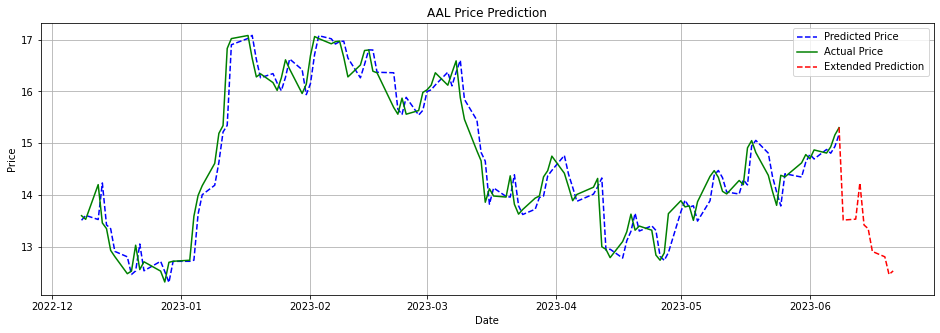

In [75]:
# Finally plotting all the dataset
plt.figure(figsize=(16,5))
plt.grid(True)
plt.plot(df_predictions, color = 'blue', linestyle = 'dashed', label = 'Predicted Price')
plt.plot(new_df_test, color = 'green', label = 'Actual Price')
plt.plot(extend_predict, color = 'red', linestyle = 'dashed', label = 'Extended Prediction')
plt.title('AAL Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [103]:
# Create dataframe for residuals
residuals = pd.DataFrame(residuals, columns=['Residual'])
residuals.index = new_date
residuals.head()

,Residual
2022-12-08,26.168460
2022-12-09,25.483951
2022-12-12,24.733927
2022-12-13,23.967594
2022-12-14,24.537648


### Performance evaluation

In [119]:
# Calculate Mean Absolute Percentage Error using the created dataframes
mape = np.mean(np.abs(np.array(df_predictions) - np.array(new_df_test))/np.abs(new_df_test))
print('MAPE: %f', % mape)

MAPE:  Actual    0.019688
dtype: float64


In [105]:
# Calculate Mean squared error for the list of expected and predicted value
mse = mean_squared_error(df_test, model_prediction)
print('MSE: %f' % mse)

MSE: 0.132535


A mean squared error of zero indicates perfect skill, or no error.

In [106]:
# Get root mean squared error
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 0.364053


As with the mean squared error, an RMSE of zero indicates no error.